<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">M2.875 · Deep Learning · Práctica</p>
<p style="margin: 0; text-align:right;">2019-2 · Máster universitario en Ciencia de datos (Data science)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudios de Informática, Multimedia y Telecomunicación</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>


# Sistema automático para la detección de COVID-19 en radiografías

Una de las aplicaciones de AI es el procesamiendo de imágenes médicas. En particular, el uso de radiografías para una detección no invasiva y rápida del Covid-19 puede resultar extremadamente útil para ayudar y agilizar la tarea del personal médico [1][2].

En este proyecto desarrollaremos un detector *Deep Learning* de Covid-19 en radiografías. Para ello, utilizaremos las imágeners de la base de datos "Covid-chestxray-dataset" [3], generada por unos investigadores del grupo de investigación [Mila](https://mila.quebec/en/) y de la Universidad de Montreal [4]. También utilizaremos imágenes de radiografías de pacientes sanos y con neumonía bacterial extraídas de la competición de Kaggle "Chest X-Ray Images (Pneumonia)" [5].

En total, disponemos de una cantidad de 426 imágenes, divididas en conjuntos de entrenamiento (339 imágenes), validación (42 imágenes) y test (45 imágenes).

Las particiones se dan en listas ".txt", en las que a cada imagen se le asigna una etiqueta:
- 0) Healthy
- 1) Covid-19
- 2) Pneumonia

El objetivo consisten en desarrollar un sistema basado en redes neuronales capaz de clasificar correctamente las imágenes en estas 3 categorías.

**<u>Nota</u>**: Los resultados obtenidos por los modelos entrenados en esta base de datos son puramente para finalidades educativas y no se pueden utilizar para un diagnóstico real sin validación clínica.

#### Referencias
1. María Climent, 2020 [Covid-19: La Inteligencia Artificial De La Española Quibim Puede Acelerar El Diagnóstico Del Coronavirus](https://innovadores.larazon.es/es/esta-inteligencia-artificial-espanola-puede-acelerar-el-diagnostico-del-coronavirus/)
2. Angel Alberich-bayarri,2020 [Imagin, AI and Radiomix to understand and fight Coronavirus Covid-19](https://quibim.com/2020/02/14/imaging-ai-and-radiomics-to-understand-and-fight-coronavirus-covid-19/)
3. [Ieee8023/covid-chestxray-dataset](https://github.com/ieee8023/covid-chestxray-dataset)
4. Cohen, J.P., Morrison, P. and Dao, L., 2020. [COVID-19 image data collection](https://arxiv.org/pdf/2003.11597.pdf).
5. Paul Mooney, 2019 [Chest X-ray Images (pneumonia)](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia)


#### Lecturas recomendadas
6. Souradip Chakraborty, 2020. [Detection Of Covid-19 Presence from Chest X-ray Scans Using Cnn & Class Activation Maps](https://towardsdatascience.com/detection-of-covid-19-presence-from-chest-x-ray-scans-using-cnn-class-activation-maps-c1ab0d7c294b)

7. Cohen, J.P., Hashir, M., Brooks, R. and Bertrand, H., 2020. [On the limits of cross-domain generalization in automated X-ray prediction](https://arxiv.org/pdf/2002.02497.pdf)

8. Karim, M., Döhmen, T., Rebholz-Schuhmann, D., Decker, S., Cochez, M. and Beyan, O., 2020. [Deepcovidexplainer: Explainable covid-19 predictions based on chest x-ray images](https://arxiv.org/pdf/2004.04582.pdf).

9. Wang, L., Wong, A. (2020). [COVID-Net: A Tailored Deep Convolutional Neural Network Design for Detection of COVID-19 Cases from Chest Radiography Images](https://arxiv.org/abs/2003.09871)

10. Zhou, B., Khosla, A., Lapedriza, A., Oliva, A. and Torralba, A., 2016. [Learning deep features for discriminative localization](https://arxiv.org/pdf/1512.04150.pdf). In Proceedings of the IEEE conference on computer vision and pattern recognition (pp. 2921-2929).

11. Mordvintsev, A., Olah, C. and Tyka, M., 2015. [Inceptionism: Going deeper into neural networks](https://ai.googleblog.com/2015/06/inceptionism-going-deeper-into-neural.html).

# Preparación del Dataset (3 puntos)

En este primer apartado se analizarán las imágenes de la base de datos y se disñará un *pipeline* para cargar las imágenes y prepararlas para la red neuronal.

Se deberán tener en cuenta factores como:
- Tamaño de entrada de las imágenes
- Normalización de las imágenes
- Visualizaciones de algunas muestras de cada categoría
- Técnicas de *data augmentation* para aumentar el tamaño del conjunto de entrenamiento

Y, en general, cualquier técnica que consideréis que pueda mejorar la implementación y resultados de este proyecto.

In [175]:
import numpy as np
import keras
import csv
import glob
import pandas as pd
import seaborn as sn
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, Activation, Dropout, MaxPooling2D, BatchNormalization, ZeroPadding2D
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras import optimizers
from PIL import Image as img
from matplotlib.pyplot import imshow
from IPython.display import Image 
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import Model
from numpy import expand_dims
%matplotlib inline

In [2]:
#############INICIO DE LA PRA
#A continuación cargaremos los conjuntos de train, test y validación.
#En primer lugar se cargará el conjunto de train en las variables x_train, que contendrá las imagenes en formato 
#np.array, e y_train, que contrendrá las categorías a las que pertenecen las imagenes.

#Por lo tanto, abrimos el fichero de texto que contiene las rutas o path de las imágenes y las etiquetas de estas:
with open('training.txt') as train_fich:
    train_reader = csv.reader(train_fich, delimiter="\t")
    train_fich_list = list(train_reader)
#Guardamos el contenido del fichero en una lista de listas, en train_fich_list[n][0] se guardarán las etiquetas 
#de las imagenes y en train_fich_list[n][1] se guardarán el path de las imagenes, donde n es el número de elementos 
#contenidos en 'training.txt'
print (train_fich_list[0][1])
print (train_fich_list[0][0])

PNEUMONIA/person888_bacteria_2812.jpeg
2


In [3]:
#Con la siguiente linea, separamos las etiquetas de las imagenes y las guardamos en una lista.
y_train=[i[0] for i in train_fich_list]
#Y obtenemos los paths de las imagenes que conforman el conjunto de train.
x_train_path=[i[1]for i in train_fich_list]
#Comprobamos que ambos vectores son de la longitud correcta (339 como se indica en el enunciado):
len (y_train), len (x_train_path)

(339, 339)

In [4]:
#Ahora debemos convertir los paths almacenados en imagenes, para ello recurrimos a la función open del
#módulo PIL, que añade capacidad de procesamiento de imagenes al a interprete Python. Se crea un bucle que va 
#recorriendo la lista donde están almacenados los paths, se convierten los path en imagenes, se ajusta el tamaño a las 
#dimensiones que necesitamos y estás imagenes a su vez en elementos np.array que finalmente serán almaceados en una 
#lista.

#La dimensión de las imagenes se fija a 224x224 ya que AlexNet (se analizará en el proximo apartado) 
#utiliza imagenes de esta dimesión como entrada a la CNN.
i=0
x_train_list=[]
l=len(x_train_path)
for i in range(l):
    img1 =img.open(x_train_path[i])
    img1=img1.resize((224,224))
    img1=img1.convert(mode='RGB')
    x_train_list.append(np.array(img1))
    i+=1

In [5]:
#El resultado de la función anterior es que tendremos una lista de elementos np.array. El último paso que se deberá
#realizar, será convertir está lista a formato np.array y normalizar sus elementos. Adicionalmente, también se 
#normalizará y se apliará un OneHotEncoder sobre la variable y_train.
x_train=np.array(x_train_list)/255
y_train=np.array(y_train)

y_train=to_categorical(y_train,3)

In [6]:
x_train.shape

(339, 224, 224, 3)

In [7]:
y_train[0]

array([0., 0., 1.], dtype=float32)

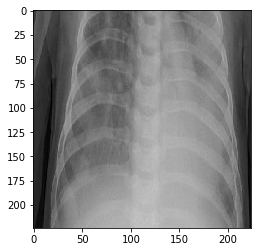

In [8]:
#Mostramos la primera imagen del conjunto:
plt.imshow(x_train[0],cmap='gray')

In [9]:
#Repetimos el proceso para el conjunto de test:

#Por lo tanto, abrimos el fichero de texto que contiene las rutas o path de las imágenes y las etiquetas de estas:
with open('testing.txt') as test_fich:
    test_reader = csv.reader(test_fich, delimiter="\t")
    test_fich_list = list(test_reader)
#Guardamos el contenido del fichero en una lista de listas, en test_fich_list[n][0] se guardarán las etiquetas 
#de las imagenes y en test_fich_list[n][1] se guardarán el path de las imagenes, donde n es el número de elementos 
#contenidos en 'testing.txt'
print (test_fich_list[0][1])
print (test_fich_list[0][0])

PNEUMONIA/person1687_bacteria_4468.jpeg
2


In [10]:
#Con la siguiente linea, separamos las etiquetas de las imagenes y las guardamos en una variable de tipo lista.
y_test=[j[0] for j in test_fich_list]
#Y obtenemos los paths de las imagenes que conforman el conjunto de test.
x_test_path=[j[1]for j in test_fich_list]
#Comprobamos que ambos vectores son de la longitud correcta:
len (y_test), len (x_test_path)

(45, 45)

In [11]:
#Ahora debemos convertir los paths almacenados en imagenes, al igual que se hizo para el conjunto de train
j=0
x_test_list=[]
l=len(x_test_path)
for j in range(l):
    img1 = img.open(x_test_path[j])
    img1=img1.resize((224,224))
    img1=img1.convert(mode='RGB')
    x_test_list.append(np.array(img1))
    j+=1

In [12]:
#El resultado de la función anterior es que tendremos una lista de elementos np.array. El último paso que se deberá
#realizar, será convertir está lista a formato np.array y normalizar sus elementos. Adicionalmente, también se 
#normalizará y se apliará un OneHotEncoder sobre la variable y_test.
x_test=np.array(x_test_list)/255
y_test=np.array(y_test)

y_test=to_categorical(y_test,3)

In [13]:
x_test.shape

(45, 224, 224, 3)

In [14]:
y_test[0]

array([0., 0., 1.], dtype=float32)

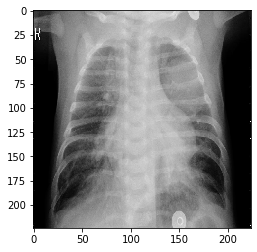

In [15]:
#Mostramos la primera imagen del conjunto:
plt.imshow(x_test[0],cmap='gray')

In [16]:
#Y por último, formamos el conjunto de validación:

#Por lo tanto, abrimos el fichero de texto que contiene las rutas o path de las imágenes y las etiquetas de estas:
with open('validation.txt') as val_fich:
    val_reader = csv.reader(val_fich, delimiter="\t")
    val_fich_list = list(val_reader)
#Guardamos el contenido del fichero en una lista de listas, en val_fich_list[n][0] se guardarán las etiquetas 
#de las imagenes y en val_fich_list[n][1] se guardarán el path de las imagenes, donde n es el número de elementos 
#contenidos en 'validation.txt'
print (val_fich_list[0][1])
print (val_fich_list[0][0])

PNEUMONIA/person1555_bacteria_4060.jpeg
2


In [17]:
#Con la siguiente linea, separamos las etiquetas de las imagenes y las guardamos en una variable de tipo lista.
y_val=[z[0] for z in val_fich_list]
#Y obtenemos los paths de las imagenes que conforman el conjunto de validación.
x_val_path=[z[1]for z in val_fich_list]
#Comprobamos que ambos vectores son de la longitud correcta:
len (y_val), len (x_val_path)

(42, 42)

In [18]:
#Ahora debemos convertir los paths almacenados en imagenes, al igual que se hizo para el conjunto de validación
z=0
x_val_list=[]
l=len(x_val_path)
for z in range(l):
    img1 = img.open(x_val_path[z])
    img1=img1.resize((224,224))
    img1=img1.convert(mode='RGB')
    x_val_list.append(np.array(img1))
    z+=1

In [19]:
#El resultado de la función anterior es que tendremos una lista de elementos np.array. El último paso que se deberá
#realizar, será convertir está lista a formato np.array y normalizar sus elementos. Adicionalmente, también se 
#normalizará y se apliará un OneHotEncoder sobre la variable y_val.
x_val=np.array(x_val_list)/255
y_val=np.array(y_val)

y_val=to_categorical(y_val,3)

In [20]:
x_val.shape

(42, 224, 224, 3)

In [21]:
y_val[0]

array([0., 0., 1.], dtype=float32)

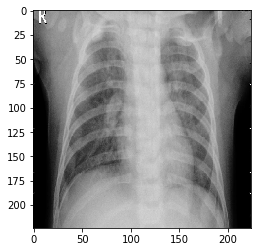

In [22]:
#Mostramos la primera imagen del conjunto:
plt.imshow(x_val[0],cmap='gray')

# Creación del modelo y métricas de evaluación (3 puntos)

En esta sección se tiene que desarrollar el *pipeline* para la creación y entrenamiento de el/los modelo/s.

Se trabajará con los datos de *training* y de *validación*.

Se deberán tener en cuenta aspectos como:
- El tipo de arquitectura más adecuado para el problema
- Las métricas que se deben utilizar para medir de forma correcta el comportamiento del modelo
- Visualizaciones de las curvas de entrenamiento/validación que ayuden a decidir cuál ha sido el mejor modelo.
- Considerar un modelo *baseline* para poder comparar las métricas (por ejemplo, utilizar predicciones aleatorias o utilizar un modelo muy sencillo, como por ejemplo una red con muy pocas capas)


In [23]:
#Según el estudio indicado en la  referencia [3], donde se realiza el análisis de las capacidades de 10 CNN 
#sobre un conjunto de imágenes médicas de pacientes con COVID-19 y pacientes sanos, la red neuronal que mejores 
#resultados presentan es AlexNet. En este apartado de diseñarán dos CNN, una red CNN simple y una red AlexNet, 
#con el fin de evaluar los resultados de ambos métodos. Adicionalmente, se estudiará la influencia de aplicar
#técnicas de Data Augmentation online sobre el conjnuto de train.

In [44]:
#CCN simple

#A continuación se crea una CCN simple, es decir, con pocas capas tanto en la etapa convolucional como en la etapa
#FC. En la etapa convolucional se define una capa convolucional con 2 kernels de tamaño 2x2. 
#En la etapa FC se define una capa Flattan qeu transforma una matriz de dos dimensiones (en este caso, nuestra 
#imagenes) en un vector que pueda ser procesado por la capa Dense de salida, en este caso con 3 nodos, ya que la
#clasificación se realizará entre 3 categorías.

def create_cnn ():
    model=Sequential()
    model.add(Conv2D(2, (2, 2), activation='relu', input_shape=(224,224, 3)))
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(3, activation='softmax'))
    return model

In [45]:
#Se crea una CNN simple, según el modelo definido anteriormente, usando Adam como optimizador.

model1=create_cnn()
model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [46]:
#A continuación, se entrena el modelo usando como conjunto de validación el validation set.
hist_model1=model1.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=20)

Train on 339 samples, validate on 42 samples
Epoch 1/20
339/339 [==============================] - 4s 11ms/step - loss: 14.4155 - accuracy: 0.4808 - val_loss: 14.2793 - val_accuracy: 0.3333
Epoch 2/20
339/339 [==============================] - 2s 7ms/step - loss: 5.7251 - accuracy: 0.6136 - val_loss: 1.9917 - val_accuracy: 0.5952
Epoch 3/20
339/339 [==============================] - 2s 7ms/step - loss: 1.7852 - accuracy: 0.7286 - val_loss: 1.0409 - val_accuracy: 0.8095
Epoch 4/20
339/339 [==============================] - 2s 7ms/step - loss: 0.6536 - accuracy: 0.8614 - val_loss: 0.4540 - val_accuracy: 0.8810
Epoch 5/20
339/339 [==============================] - 2s 7ms/step - loss: 0.5195 - accuracy: 0.8850 - val_loss: 0.5584 - val_accuracy: 0.8810
Epoch 6/20
339/339 [==============================] - 2s 7ms/step - loss: 0.4281 - accuracy: 0.9204 - val_loss: 0.3627 - val_accuracy: 0.8810
Epoch 7/20
339/339 [==============================] - 2s 7ms/step - loss: 0.3556 - accuracy: 0.9174 

In [25]:
#Vamos a aplicar real time Data Augmentation, realizando rotación, desplazamiento y volteo de imagenes del conjunto
#de train.
train_aug = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

In [51]:
#CNN simple con DATA AUGMENTATION

#Para ello se crea un nuevo modelo, simétrico al usado en anteriormente ya que el objetivo es analizar la influencia
#del Data Augmentation.
model2=create_cnn()
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [52]:
#A continuación, se entre el modelo usando como conjunto de validación el validaton set y aplication online 
#Data Augmentation al train set.
hist_model2=model2.fit(train_aug.flow(x_train, y_train), validation_data=(x_val, y_val), epochs=20)

Epoch 1/20
11/11 [==============================] - 7s 627ms/step - loss: 11.8532 - accuracy: 0.3333 - val_loss: 6.1231 - val_accuracy: 0.4762
Epoch 2/20
11/11 [==============================] - 6s 557ms/step - loss: 4.3275 - accuracy: 0.4336 - val_loss: 1.4092 - val_accuracy: 0.5238
Epoch 3/20
11/11 [==============================] - 6s 569ms/step - loss: 1.0720 - accuracy: 0.6283 - val_loss: 1.0650 - val_accuracy: 0.7381
Epoch 4/20
11/11 [==============================] - 6s 553ms/step - loss: 1.1332 - accuracy: 0.7345 - val_loss: 0.6545 - val_accuracy: 0.8095
Epoch 5/20
11/11 [==============================] - 6s 565ms/step - loss: 0.8149 - accuracy: 0.7434 - val_loss: 0.7602 - val_accuracy: 0.7857
Epoch 6/20
11/11 [==============================] - 6s 554ms/step - loss: 0.7763 - accuracy: 0.7611 - val_loss: 0.6538 - val_accuracy: 0.8095
Epoch 7/20
11/11 [==============================] - 6s 557ms/step - loss: 0.7551 - accuracy: 0.7699 - val_loss: 0.7514 - val_accuracy: 0.7381
Epoch

In [31]:
#Vemos que en este caso se obtiene mejor resultado cuando no usamos Data Augmentation. Como futuros pasos,
#se podría probar con el Data Augmentation manual en lugar de online, donde añadimos añadiríamos nuevas imagenes
#al train set de forma manual. Adicionalmente, también se podría aplicar Data Augmentation sobre el conjunto de 
#validación y analizar si mejoran los resultados.

In [36]:
def create_AlexNet():
    model = Sequential()

    # Primera Capa Convolucional 
    
    #Con 96 kernels de 11x11, stride de 4, habilitando padding y con una entrada 
    #de 224x224x3.
    model.add(Conv2D(filters=96, input_shape=(224,224,3), kernel_size=(11,11),strides=(4,4), padding='valid'))
    model.add(Activation('relu'))
    # Capa de Pooling, con un kernel de 2x2, stride de 2 y padding habilitado.
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
    # Batch Normalisation antes de pasar a la siquiete capa.
    model.add(BatchNormalization())

    # Segunda Capa Convolucional
    
    #Con 256 kernels de 11x11, stride de 4, habilitando padding.
    model.add(Conv2D(filters=256, kernel_size=(11,11), strides=(1,1), padding='valid'))
    model.add(Activation('relu'))
    # Capa de Pooling, con un kernel de 2x2, stride de 2 y padding habilitado.
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
    # Batch Normalisation antes de pasar a la siquiete capa.
    model.add(BatchNormalization())

    # Tercera Capa Convolucional
    
    #Con 384 kernels de 3x3, stride de 1, habilitando padding.
    model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid'))
    model.add(Activation('relu'))
    # Batch Normalisation
    model.add(BatchNormalization())

    # Cuarta Capa Convolucional
    
    #Con 384 kernels de 3x3, stride de 1, habilitando padding.
    model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid'))
    model.add(Activation('relu'))
    # Batch Normalisation
    model.add(BatchNormalization())

    # Quinta Capa Convolucional
    
    #Con 256 kernels de 3x3, stride de 1, habilitando padding.
    model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='valid'))
    model.add(Activation('relu'))
    # Capa de Pooling, con un kernel de 2x2, stride de 2 y padding habilitado.
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
    # Batch Normalisation
    model.add(BatchNormalization())

    # Pasamos a la etapa Fully Connected (FC)
    model.add(Flatten())
    # Primera capa Dense
    model.add(Dense(4096))
    model.add(Activation('relu'))
    # Se introduce Dropout con probabilidad igual a 0.4 para evitar overfitting.
    model.add(Dropout(0.4))
    # Batch Normalisation
    model.add(BatchNormalization())

    # Segunda capa Dense
    model.add(Dense(4096))
    model.add(Activation('relu'))
    # # Se introduce Dropout
    model.add(Dropout(0.4))
    # Batch Normalisation
    model.add(BatchNormalization())

    # Tercera capa Dense
    model.add(Dense(1000))
    model.add(Activation('relu'))
    # Se introduce Dropout
    model.add(Dropout(0.4))
    # Batch Normalisation
    model.add(BatchNormalization())

    # Capa de salida con 3 nodos, dado que la clasificación se realizará entre 3 categorías
    model.add(Dense(17))
    model.add(Dense(3, activation='softmax'))
    
    return model

In [48]:
#Se crea el modelo AlexNet según se definió anteriormente
model3=create_AlexNet()
model3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [49]:
hist_model3=model3.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=20)

Train on 339 samples, validate on 42 samples
Epoch 1/20
339/339 [==============================] - 67s 196ms/step - loss: 2.2475 - accuracy: 0.6490 - val_loss: 87.5911 - val_accuracy: 0.3333
Epoch 2/20
339/339 [==============================] - 62s 183ms/step - loss: 1.0922 - accuracy: 0.7699 - val_loss: 135.8216 - val_accuracy: 0.3333
Epoch 3/20
339/339 [==============================] - 62s 183ms/step - loss: 0.6175 - accuracy: 0.7994 - val_loss: 142.5818 - val_accuracy: 0.3333
Epoch 4/20
339/339 [==============================] - 62s 183ms/step - loss: 0.5526 - accuracy: 0.8496 - val_loss: 73.2208 - val_accuracy: 0.3333
Epoch 5/20
339/339 [==============================] - 64s 188ms/step - loss: 0.5105 - accuracy: 0.8643 - val_loss: 24.7920 - val_accuracy: 0.3333
Epoch 6/20
339/339 [==============================] - 63s 185ms/step - loss: 0.5430 - accuracy: 0.8230 - val_loss: 18.9790 - val_accuracy: 0.3333
Epoch 7/20
339/339 [==============================] - 63s 187ms/step - loss: 

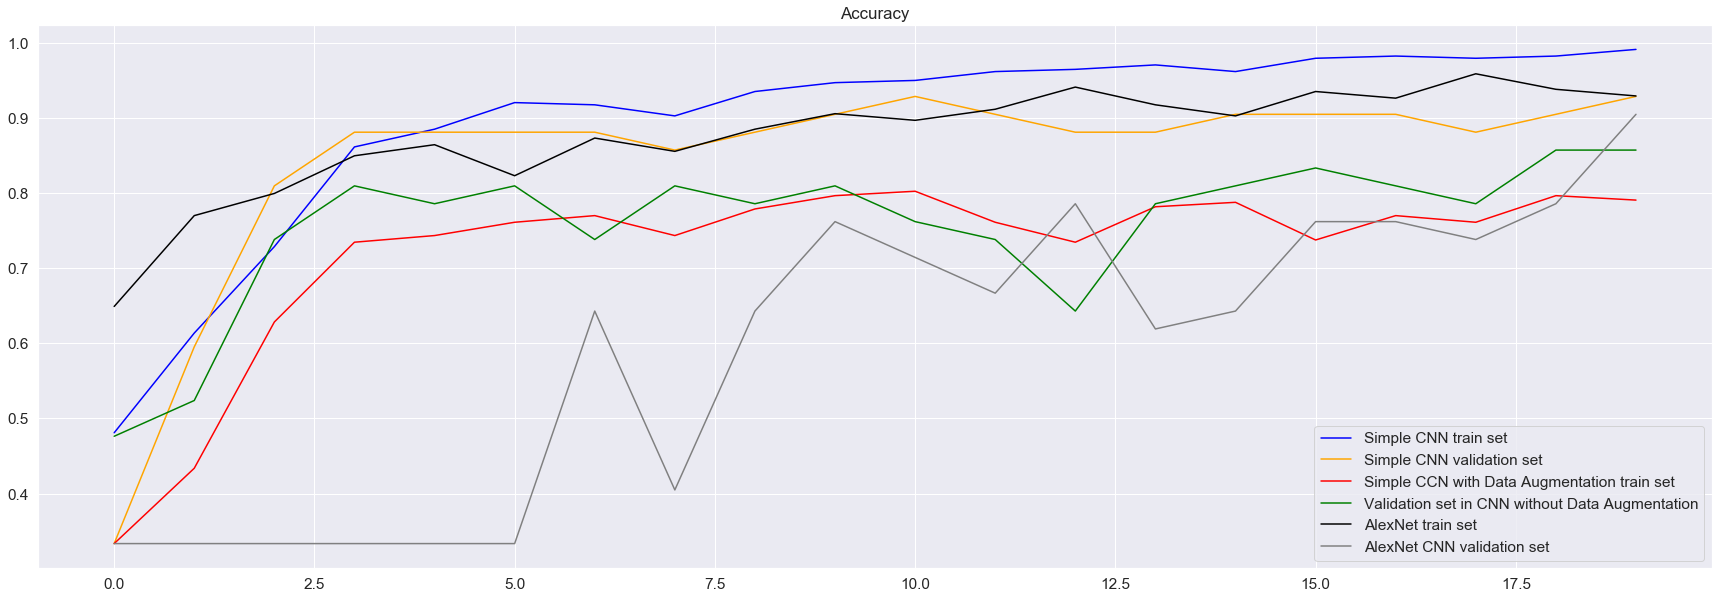

In [108]:
#Representamos la evolución de la Precisión para los train y validation set de los tres modelos: 
    #-CNN simple
    #-CNN simple con Data Augmentation
    #-AlexNet
plt.title('Accuracy')
plt.plot(hist_model1.history['accuracy'], color='blue', label='Simple CNN train set')
plt.plot(hist_model1.history['val_accuracy'], color='orange', label='Simple CNN validation set')
plt.plot(hist_model2.history['accuracy'], color='red', label='Simple CCN with Data Augmentation train set')
plt.plot(hist_model2.history['val_accuracy'], color='green', label='Simple CNN without Data Augmentation validation set')
plt.plot(hist_model3.history['accuracy'], color='black', label='AlexNet train set')
plt.plot(hist_model3.history['val_accuracy'], color='gray', label='AlexNet CNN validation set')

plt.legend(['Simple CNN train set', 'Simple CNN validation set',
 'Simple CCN with Data Augmentation train set','Validation set in CNN without Data Augmentation','AlexNet train set',
           'AlexNet CNN validation set'])
plt.rcParams["figure.figsize"] = [30,10]
plt.show(1)

# Resultados y Conclusiones (3 puntos)

En esta sección se debe implementar la fase de test de los mejores modelos desarrollados anteriormente.

Se valorarán aspectos como:
- Razonamiento de qué arquitectura es la más adecuada
- Análisis cuantitativo y cualitativo de los resultados.

In [56]:
#En este apartado se evalua, sobre el conjunto de test, los clasificadores obtenidos al entrenar los distintos 
#modelos con el train set.

#En primer lugar, evaluamos sobre el conjunto de test el clasificador obtenido al entrenar el modelo CNN Simple.
_, acc1 = model1.evaluate(x_test, y_test, verbose=0)
print('%.3f' % (acc1 * 100.0))

84.444


In [167]:
#Obtenemos la matrix de confusión para el modelo CNN simple
labTrue=["HEALTHY:actual","COVID-19:actual","PNEUMONIA:actual"]
labPred=["HEALTHY:pred","COVID-19:pred","PNEUMONIA:pred"]
y_pred1 = model1.predict_classes(x_test, verbose=0)
y_test_real=np.argmax(y_test, axis=1)
conf_matrix1 = confusion_matrix(y_test_real, y_pred1)
df_conf_matrix1 = pd.DataFrame(conf_matrix1, index = labTrue,
                  columns = labPred)
df_conf_matrix1

,HEALTHY:pred,COVID-19:pred,PNEUMONIA:pred
HEALTHY:actual,13,0,2
COVID-19:actual,1,14,0
PNEUMONIA:actual,4,0,11


In [142]:
#En segundo lugar, evaluamos sobre el conjunto de test el clasificador obtenido al entrenar el modelo CNN Simple
#con Data Augmentation.
_, acc2 = model2.evaluate(x_test, y_test, verbose=0)
print('%.3f' % (acc2 * 100.0))

80.000


In [168]:
#Obtenemos la matrix de confusión para el modelo CNN simple con Data Augmentation
y_pred2 = model2.predict_classes(x_test, verbose=0)
conf_matrix2 = confusion_matrix(y_test_real, y_pred2)
df_conf_matrix2 = pd.DataFrame(conf_matrix2, index = labTrue,
                  columns = labPred)
df_conf_matrix2

,HEALTHY:pred,COVID-19:pred,PNEUMONIA:pred
HEALTHY:actual,13,1,1
COVID-19:actual,0,15,0
PNEUMONIA:actual,6,1,8


In [144]:
#En último lugar, se evalua el modelo sobre el conjunto de test el clasificador obtenido al entrenar el modelo 
#AlexNet.
_, acc3 = model3.evaluate(x_test, y_test, verbose=0)
print('%.3f' % (acc3 * 100.0))

88.889


In [169]:
#Obtenemos la matrix de confusión para el modelo AlexNet
y_pred3 = model3.predict_classes(x_test, verbose=0)
conf_matrix3 = confusion_matrix(y_test_real, y_pred3)
df_conf_matrix3 = pd.DataFrame(conf_matrix3, index = labTrue,
                  columns = labPred)
df_conf_matrix3

,HEALTHY:pred,COVID-19:pred,PNEUMONIA:pred
HEALTHY:actual,14,0,1
COVID-19:actual,0,15,0
PNEUMONIA:actual,3,1,11


In [171]:
#Analisis

#De cara a analizar los resultados se van a tomar de referencia tres elementos, que hemos calculado anteriormente.

#En primer lugar, se ha representado la evolución de la precisión, en función de las épocas, para los tres modelos
#analizados. Se observa que el modelo que mejor precisión presenta sobre el gráfico es el modelo CNN simple, 
#alcanzando tasas de 99% de precisión para el train set. El segundo modelo que mejor precisión presenta sobre el
#gráfico es AlexNet y, por último, tendríamos al modelo CNN simple con Data Augmentation.

#En segundo lugar, hemos evaluado los modelos obtenidos, entrenados a través del train set, sobre el conjunto de 
#test. En este caso se observa que el modelo que mejor resultados presenta es AlexNet, obteniendo una precisión 
#general del modelo de 88,88%. En segundo lugar, vemos que el modelo CNN simple proporciona un 84,44% de precisión
#sobre el conjunto de test y, por último, el modelo CNN simple con Data Augmentation proporciona un 80% de precisión.

#En tercer lugar, se ha generado una matriz de confusión para cada modelo, y en particular AlexNet ha mostrado un
#100% de precisión a la hora de detectar COVID-19, ya que detectó los 15 casos correspondiente al virus. Por su 
#lado, el modelo CNN Simple predijo como HEALTHY una muestra que pertenecía a COVID-19.

#Podemos afirmar que el modelo CNN simple presenta overfitting ya que, sobre el train set presenta valores muy 
#altos de precisión, sin embargo, no es capaz de generalizar igual de bien para otros conjuntos de datos. 
#Adicionalmente, AlexNet presenta mejor ratio de precisión al clasificar muestras con COVID-19, que es el objetivo
#principal de esta práctica.

#Por lo tanto, se puede concluir que AlexNet generaliza y clasifica las muestras con COVID-19 mejor que el modelo
#CNN simple, por lo tanto, sería la mejor opción para la detección de COVID-19.

In [146]:
#Elección del modelo de deep learning.

#Para cerrar el apartado de análisis, se ha decidió trabajar con el modelo de deep learning AlexNet [13] por 
#distintas razones:
#1. Muestra muy buenos resultados a la hora de trabajar con Datasets pequeños [12],[14],[15],[16]
#2. Aún siendo un modelo con muchas capas convolucionales, permite trabajar de forma eficiente con imagenes de 
#alta resulución.
#3. Es uno de los métodos que mejores resultados obtiene al trabajar con imagenes médicas [12],[14],[15],[16],[17].
#4. Introduce capas de Dropout y Normalización para eliminar overfitting.
#5. Para futuros trabajos, su arquitectura está optimizada para trabajar de forma eficiente con GPUs.

# *Explainability* (1 punto)

Investiga sobre las técnicas que se utilizan para entender las decisiones de una CNN. Por ejemplo, los [Class Activation Maps](https://arxiv.org/pdf/1512.04150.pdf) (CAM)[4] son una modificación en la arquitectura de una CNN de clasificación de imágenes que permite visualizar qué partes de la imagen se consideran para la clasificación de una muestra con una determinada etiqueta. Variaciones de las CAMs se han aplicado recientemente para entender el comportamiento de las redes para detectar Covid-19 [8].

Otro método es el popular [Deep Dream](https://deepdreamgenerator.com/)[11]. Este método, a parte de generar imágenes con un estilo artístico/psicodélico, sirve para entender el tipo de características que busca una red en la imagen de entrada para clasificarla con una determinada etiqueta.

Implementa alguna técnica de visualización para intentar entender las decisiones de la CNN entrenada.

In [ ]:
#A continuación se puede ver el efecto de la primera capa convolucional sobre una imagen en particular. Es una 
#forma de ver como está trabajando el modelo AlexNet sobre una imagen. Este proceso se podría aplicar para cada 
#una de las capas del modelo y para cada una de las imágenes. 

#Vemos que algunos filtros se centran en la zona osea y la mayoria de filtros se centran en la masa correspondiente
#a los pulmones.

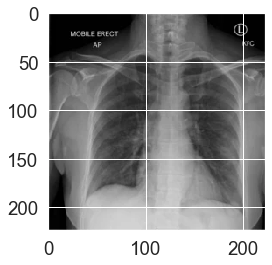

In [181]:
#Se va a analizar la influencia de las capas convolucionales sobre la siguiente imagen.
img_CAM = load_img('COVID-19/41591_2020_819_Fig1_HTML.webp-day10.png', target_size=(224, 224))
plt.imshow(img_CAM,cmap='gray')

Model: "model_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14_input (InputLayer) (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 54, 54, 96)        34944     
_________________________________________________________________
activation_17 (Activation)   (None, 54, 54, 96)        0         
Total params: 34,944
Trainable params: 34,944
Non-trainable params: 0
_________________________________________________________________


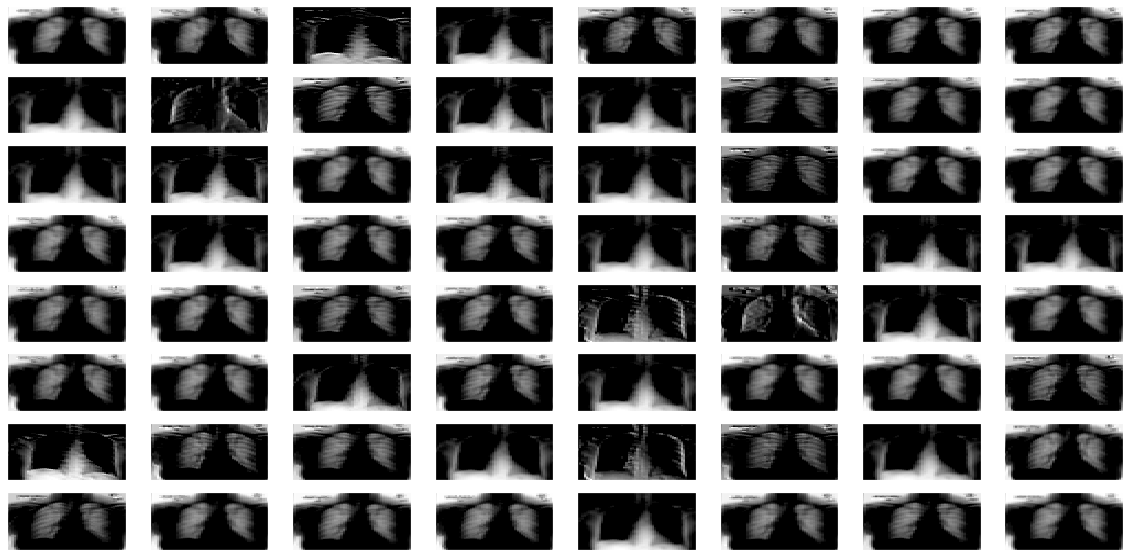

In [215]:
#Se carga en la variable model la primera capa convolucional del modelo AlexNet creado.
model = Model(inputs=model3.inputs, outputs=model3.layers[1].output)
model.summary()
# Se carga la imagen con el tamaño correspondiente
img_CAM = load_img('COVID-19/41591_2020_819_Fig1_HTML.webp-day10.png', target_size=(224, 224))
# Se convierte la imagen a array
img_CAM = img_to_array(img_CAM)
# Se expande la dimensión
img_CAM = expand_dims(img_CAM, axis=0)
# Se preprocesan los pixels de la imagen acorde a la primera capa convolucional
img_CAM = preprocess_input(img_CAM)
# Se obtiene el mapa de caracteristicas trás la primera capa convolucional
feature_maps = model.predict(img_CAM)
# Se muestras 64 muestras en una matriz de 8x8
square = 8
ix = 1
for _ in range(square):
	for _ in range(square):
		ax = plt.subplot(square, square, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		plt.imshow(feature_maps[0, :, :, ix-1], cmap='gray',aspect='auto')
		ix += 1
plt.rcParams["figure.figsize"] = [10,5]
plt.show()

In [ ]:
#REFERENCIAS

#1.  https://stackoverflow.com/questions/26649716/how-to-show-pil-image-in-ipython-notebook
#2.  https://github.com/casperbh96/COVID-19-Detection/blob/master/Deep_Learning_for_COVID_19.ipynb
#3.  https://www.sciencedirect.com/science/article/pii/S0010482520301645
#4.  https://stackoverflow.com/questions/50243709/how-to-convert-a-1-channel-image-into-a-3-channel-with-pil
#5.  https://github.com/casperbh96/COVID-19-Detection/blob/master/Deep_Learning_for_COVID_19.ipynb
#6.  https://engmrk.com/alexnet-implementation-using-keras/?utm_campaign=News&utm_medium=Community&utm_source=DataCamp.com
#7.  https://towardsdatascience.com/building-convolutional-neural-networks-in-python-using-keras-7e4652f6456f
#8.  https://towardsdatascience.com/image-detection-from-scratch-in-keras-f314872006c9
#9.  https://keras.io/api/preprocessing/image/
#10. https://pillow.readthedocs.io/en/4.2.x/reference/Image.html
#11. https://stackoverflow.com/questions/37631611/python-how-to-resize-an-image-using-pil-module
#12. https://www.learnopencv.com/understanding-alexnet/
#13. https://www.mydatahack.com/building-alexnet-with-keras/
#14. Loey, M.; Smarandache, F.; M. Khalifa, N.E. Within the Lack of Chest COVID-19 X-ray Dataset: A Novel Detection Model 
     #Based on GAN and Deep Transfer Learning. Symmetry 2020, 12, 651.
#15. https://d2l.ai/chapter_convolutional-modern/alexnet.html
#16. Loey, M.; Smarandache, F.; M. Khalifa, N.E. A Deep Transfer Learning Model with Classical Data Augmentation and CGAN 
     #to Detect COVID-19 from Chest CT Radiography Digital Images. Preprints 2020, 2020040252 (doi: 10.20944/preprints202004.0252.v1)
#17. https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5479722/    
#18. https://stackoverflow.com/questions/54589669/confusion-matrix-error-classification-metrics-cant-handle-a-mix-of-multilabel